# Stream-based Active Learning With River

In this notebook, we will show how stream-based active learning strategies are used and compared them to one another. We showcase compatibility between the the methods available in the `skactiveml` stream package and the `river` library. 

In [1]:
import sys
sys.path.append("..")
import numpy as np
from collections import deque
import sklearn
import sklearn.datasets
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from skactiveml.classifier import SklearnClassifier, SlidingWindowClassifier
from skactiveml.stream import StreamRandomSampling, PeriodicSampling
from skactiveml.stream import FixedUncertainty, VariableUncertainty, Split, StreamProbabilisticAL, StreamDensityBasedAL, CognitiveDualQueryStrategyRan, CognitiveDualQueryStrategyFixUn, CognitiveDualQueryStrategyRanVarUn, CognitiveDualQueryStrategyVarUn
from skactiveml.utils import call_func
from river.compat import River2SKLClassifier
from river.tree import HoeffdingTreeClassifier

## Initialize Stream Parameters
Before the experiments can start, we need to construct an artificial data set. For this, we specify the necessary parameters in the cell below. We specify the length of the data stream `stream_length` and the size of the sliding window that defines the available training data `training_size`. Additionally we define a parameter `fit_clf` to decide if `X` and `y` are needed and should be used.

In [2]:
# number of instances that are provided to the classifier
init_train_length = 10
# the length of the data stream
stream_length = 10000
# the parameter dedicated to decide if the classifier needs to be refited with X and y.
fit_clf = False

## Random Seed Generation
To make the experiments repeatable, we will use the `random_state` object to generate all other random seeds, such that we only need to explicitly specify a single random seed. The `get_randomseed` function simplifies the generation of a new random seed using the `random_state` object.

In [3]:
# random state that is used to generate random seeds
random_state = np.random.RandomState(42)

def get_randomseed(random_state):
    return random_state.randint(2**31-1)

## Generate And Initialize Data Set
The next block initializes the tested data set. We use `scikit-learn` to generate a random data set with our pre-defined stream length. The data set consists of multiple parts. `X` represents the location of the instance within the feature space. The class for each instance is denoted by `y`. 
For models that need at least some initial training data, we generate samples to train an initial model. These are denoted by the suffix "_init", while all data used within the active learning cycle are denoted by the suffix "_stream". For this notebook we evaluate the performance of each query strategy using Prequential Evaluation. If a hold-out test data set is used, it should be initialized here as well.

In [4]:
X, y_centers = sklearn.datasets.make_blobs(
    n_samples=init_train_length + stream_length,
    centers=30,
    random_state=get_randomseed(random_state),
    shuffle=True)
y = y_centers % 2
X_init = X[:init_train_length, :]
y_init = y[:init_train_length]
X_stream = X[init_train_length:, :]
y_stream = y[init_train_length:]

## Initialize Query Strategies
Next, we initialize the classifier and the base query strategies that we want to compare. To use the classifier we first need to convert the river classifier to an sklearn classifier by using their converter `River2SKLClassifier`. To guarantee that the classifier is not affected by previous repetitions, we use factory functions to separate the classifier for each experiment run. Since all query strategies have a default budget managager we use that for the sake of simplicity.

In [5]:
classes = np.unique(y)
clf_factory = lambda: SklearnClassifier(
        River2SKLClassifier(HoeffdingTreeClassifier()),
        random_state=get_randomseed(random_state),
        classes=classes)
query_strategies = {
    'RandomSampler': StreamRandomSampling(random_state=get_randomseed(random_state)),
    # 'PeriodicSampler': PeriodicSampling(random_state=get_randomseed(random_state)),
    # 'FixedUncertainty': FixedUncertainty(random_state=get_randomseed(random_state)),
    # 'VariableUncertainty': VariableUncertainty(random_state=get_randomseed(random_state)),
    'Split': Split(random_state=get_randomseed(random_state)),
    'StreamProbabilisticAL': StreamProbabilisticAL(random_state=get_randomseed(random_state), metric="rbf"),
    'DBStream': StreamDensityBasedAL(random_state=get_randomseed(random_state)),
    # 'CogDQSRan': CognitiveDualQueryStrategyRan(random_state=get_randomseed(random_state), force_full_budget=True),
    'CogDQSRanVarUn': CognitiveDualQueryStrategyRanVarUn(random_state=get_randomseed(random_state), force_full_budget=True),
    # 'CogDQSVarUn': CognitiveDualQueryStrategyVarUn(random_state=get_randomseed(random_state), force_full_budget=True),
    # 'CogDQSFixUn': CognitiveDualQueryStrategyFixUn(random_state=get_randomseed(random_state), force_full_budget=True),
}

## Start Active Learning Cycle
After all, variables are initialized, we can start the experiment. The experiment loop below goes through all query strategies defined in query_strategies. For each experiment run, the average accuracy of the selected query strategies will be displayed. Lastly, the accuracy over time will be plotted.

Query Strategy:  RandomSampler , Avg Accuracy:  0.5803 , Acquisation count: 1035
Query Strategy:  Split , Avg Accuracy:  0.6371 , Acquisation count: 1037
Query Strategy:  StreamProbabilisticAL , Avg Accuracy:  0.6452 , Acquisation count: 999
Query Strategy:  DBStream , Avg Accuracy:  0.5913 , Acquisation count: 1000
Query Strategy:  CogDQSRanVarUn , Avg Accuracy:  0.6035 , Acquisation count: 1033


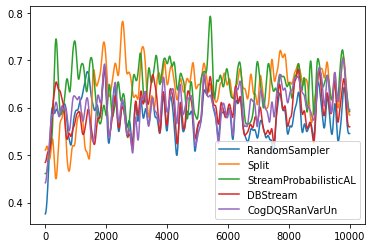

In [6]:
for query_strategy_name, query_strategy in query_strategies.items():
    clf = clf_factory()
    # save X and y using a sliding window
    X_train = deque(maxlen=1000)
    X_train.extend(X_init)
    y_train = deque(maxlen=1000)
    y_train.extend(y_init)
    # train the model with the initially available data
    clf.fit(X_init, y_init)
    # initialize the list that stores the result of the classifier's prediction
    correct_classifications = []
    count = 0
    for x_t, y_t in zip(X_stream, y_stream):
        X_cand = x_t.reshape([1, -1])
        y_cand = y_t
        correct_classifications.append(clf.predict(X_cand)[0] == y_cand)
        # check whether to sample the instance or not
        # call_func is used since a classifier is not needed for RandomSampler and PeriodicSampler
        sampled_indices, utilities = call_func(query_strategy.query, candidates=X_cand, X=X_train, y=y_train, clf=clf, return_utilities=True, fit_clf=False)
        # create budget_manager_param_dict for BIQF used by PALS
        budget_manager_param_dict = {"utilities": utilities}
        # update the query strategy and budget_manager to calculate the right budget
        call_func(query_strategy.update, candidates=X_cand, queried_indices=sampled_indices, budget_manager_param_dict=budget_manager_param_dict)
        if len(sampled_indices):
            count += 1
        # train the classifier
        if len(sampled_indices):
            clf.partial_fit(X_cand, np.array([y_cand]))
        # add X_cand to X_train
        X_train.append(x_t)
        # add label or missing_label to y_train
        y_train.append(y_cand if len(sampled_indices) > 0 else clf.missing_label)
    # calculate and show the average accuracy 
    print("Query Strategy: ", query_strategy_name, ", Avg Accuracy: ", np.mean(correct_classifications), ", Acquisation count:", count)
    plt.plot(gaussian_filter1d(np.array(correct_classifications, dtype=float), 50), label=query_strategy_name)
plt.legend();